In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import h5py
import PIL
import sys  
import os
import torch
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
#from data.convert_distance_to_depth import * 
from set_method import my_method, Method


module_path = os.path.abspath(os.path.dirname(os.getcwd()))+"/../" # Only works if cwd correctly gets the model folder.


if module_path not in sys.path:
    sys.path.append(module_path)

from data.convert_distance_to_depth import *
from loaddata import *



    

In [4]:
#test_dataframe = pd.read_csv("../../data/downloads/image_file_test.csv")

# Validation from the cluster:
# Depth,Segmentation,ToneMapped
# ai_001_001/images/scene_cam_00_geometry_hdf5/frame.0006.depth_meters.hdf5,ai_001_001/images/scene_cam_00_geometry_hdf5/frame.0006.semantic.hdf5,ai_001_001/images/scene_cam_00_final_preview/frame.0006.tonemap.jpg
os.environ["THREED_VISION_ABSOLUTE_DOWNLOAD_PATH"] = "/home/user/ethz/semester4/3dVision/3DVision--Infusing-Monocular-Depth-Semantic/data/downloads/"
# os.environ["THREED_VISION_ABSOLUTE_DOWNLOAD_PATH"] = "/home/user/Nextcloud/Documents/ETHZ/semester4/3dVision/3DVision--Infusing-Monocular-Depth-Semantic/data/downloads/"
download_path = os.getenv("THREED_VISION_ABSOLUTE_DOWNLOAD_PATH") or "/home/user/ethz/semester4/3dVision/3DVision--Infusing-Monocular-Depth-Semantic/data/downloads/"
validation_image_path = ["ai_001_001/images/scene_cam_00_geometry_hdf5/frame.0006.depth_meters.hdf5","ai_001_001/images/scene_cam_00_geometry_hdf5/frame.0006.semantic.hdf5","ai_001_001/images/scene_cam_00_final_preview/frame.0006.tonemap.jpg"]
validation_image_path_csv = "../outputs/results/"+ "valid_image.csv"
validation_tensor_path = "../outputs/results/"+ "validation-.05-10-2023-14-59-41-depth.pt"

my_method = Method.NOSEGMENTATIONCUES

mean,std = [0.53277088, 0.49348648, 0.45927282],[0.238986 ,  0.23546355 ,0.24486044] 

if(torch.cuda.is_available()):
    device = "cuda:0"
else:device="cpu"

In [5]:
def display_tensor_data(tensor, remap=None):
    if remap != None:
        tensor = remap(tensor)
    fig, (ax) = plt.subplots(1)
    pcm = ax.imshow(tensor.permute(1,2,0))
    fig.colorbar(pcm, ax=ax) #ticks=[-1, 0, 1]) 
    plt.show()
    
def display_tensor_data_many(tensors,remap=None,titles=None,figsize=(15,15),fontsize=12):
    nb = len(tensors)
    if titles is None:
        titles = ["Prediction","Ground Truth", "RGB Input"]
    fig, axes = plt.subplots(1,nb, layout='constrained',figsize=figsize)
    if remap is not None:
        for i in range(nb):
            if remap[i] is not None:
                tensors[i] = remap[i](tensors[i])
                
         
    for i,ax in enumerate(axes) :
        pcm = ax.imshow(tensors[i].permute(1,2,0))
        ax.set_title(titles[i], fontsize=fontsize)
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        fig.colorbar(pcm, cax=cax) #ticks=[-1, 0, 1]) 
    plt.show()
    
def display_image_pairs(rgb_image_tensor, segmentation):
    fig, axs = plt.subplots(2)
    axs[0].imshow(rgb_image_tensor.permute(1,2,0))
    axs[1].imshow(segmentation)
    plt.show()
    
def compute_error(ground_truth_depth, depth_output):
    error = torch.abs(ground_truth_depth - depth_output); 
    thr = 0.6;
    error[error < thr] = 0
    return error
        
def display_image_triplets(ground_truth_depth, depth_output):
    
    print("Depth max: ", depth_output.max())
    print("Depth min: ", depth_output.min())
    print("Depth groundtruth max: ", ground_truth_depth.max())
    print("Depth groundtruth min: ", ground_truth_depth.min())
    error = compute_error(ground_truth_depth, depth_output)
        
    print("Error max: ", error.max())
    print("Error min: ", error.min())
    min_scale = min(ground_truth_depth.min(), depth_output.min())
    max_scale = max(ground_truth_depth.max(), depth_output.max())
    if ground_truth_depth.isnan().any():
        temp = ground_truth_depth
        temp[temp.isnan()] = 3; 
        min_scale = min(temp.min(), depth_output.min())
        max_scale = max(temp.max(), depth_output.max())
        print("Min_Scale: ", min_scale)
        print("Max_Scale: ", max_scale)
        
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12, 16))
    pcm = axs[0].imshow(ground_truth_depth.permute(1,2,0), vmax = max_scale, vmin = min_scale)
    fig.colorbar(pcm, ax=axs[0],fraction=0.046, pad=0.04)
    pcm2 = axs[1].imshow(depth_output.permute(1,2,0), vmax = max_scale, vmin = min_scale)
    fig.colorbar(pcm2, ax=axs[1], fraction=0.046, pad=0.04)
    pcm3 = axs[2].imshow(error.permute(1,2,0))
    fig.colorbar(pcm3, ax=axs[2],fraction=0.046, pad=0.04)
    fig.tight_layout()
    plt.show()
    #plt.savefig("plots/")

    
def plot(ground_truth_depth, depth_output, rgb_image, plot_name):
    print("Depth max: ", depth_output.max())
    print("Depth min: ", depth_output.min())
    print("Depth groundtruth max: ", ground_truth_depth.max())
    print("Depth groundtruth min: ", ground_truth_depth.min())
    error = compute_error(ground_truth_depth, depth_output)
        
    print("Error max: ", error.max())
    print("Error min: ", error.min())
    min_scale = min(ground_truth_depth.min(), depth_output.min())
    max_scale = max(ground_truth_depth.max(), depth_output.max())
    if ground_truth_depth.isnan().any():
        temp = ground_truth_depth
        temp[temp.isnan()] = 3; 
        min_scale = min(temp.min(), depth_output.min())
        max_scale = max(temp.max(), depth_output.max())
        print("Min_Scale: ", min_scale)
        print("Max_Scale: ", max_scale)
        
    fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(12, 16))
    axs[0].imshow(rgb_image.permute(1,2,0))
    axs[0].set_xlabel("Input Image")
    pcm = axs[1].imshow(ground_truth_depth.permute(1,2,0), vmax = max_scale, vmin = min_scale)
    fig.colorbar(pcm, ax=axs[1],fraction=0.046, pad=0.04)
    axs[1].set_xlabel("Ground Truth Depthmap in meters")
    pcm2 = axs[2].imshow(depth_output.permute(1,2,0), vmax = max_scale, vmin = min_scale)
    fig.colorbar(pcm2, ax=axs[2], fraction=0.046, pad=0.04)
    axs[2].set_xlabel("Model Output Depthmap in meters")
    pcm3 = axs[3].imshow(error.permute(1,2,0))
    fig.colorbar(pcm3, ax=axs[3],fraction=0.046, pad=0.04)
    axs[3].set_xlabel("L1 error thresholded at 0.6 m")
    fig.tight_layout()
    plt.show()
    fig.savefig(plot_name, bbox_inches='tight')
    

def normalize(tensor, mean, std):
    """Normalize a tensor image with mean and standard deviation.
    See ``Normalize`` for more details.
    Args:
        tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        mean (sequence): Sequence of means for R, G, B channels respecitvely.
        std (sequence): Sequence of standard deviations for R, G, B channels
            respecitvely.
    Returns:
        Tensor: Normalized image.
    """

    # TODO: make efficient
    tensor_copy = tensor.clone().detach()
    for t, m, s in zip(tensor_copy, mean, std):
        print(t.min())
        print(t.max())
        t.sub_(m).div_(s)
        print(t.min())
        print(t.max())
        
        
    return tensor_copy

def denormalize(image_input):
    image = image_input.clone().detach()
    for channel in range(0, image.shape[0]):
        image[channel,:,:].mul_(std[channel]).add_(mean[channel])
    return image

In [6]:
def test_sample(model, test_loader): 
    model.eval()
    depth_results = []
    if(torch.cuda.is_available()):
        model.to("cuda:0")
    else:model.to("cpu")
    for i, sample_batched in enumerate(test_loader):
        torch.cuda.empty_cache()
        
        image, depth = sample_batched['image'], sample_batched['depth']
        if(torch.cuda.is_available()):
            depth = depth.cuda(non_blocking=True) #
            image = image.cuda()
        image = torch.autograd.Variable(image, requires_grad=False)
        depth = torch.autograd.Variable(depth, requires_grad=False)
        output = model(image)
        output = torch.nn.functional.interpolate(output, size=[depth.size(2),depth.size(3)], mode='bilinear')
        #display_tensor_data(output[0,:].detach())
        #display_tensor_data(depth[0,:])
        #plt.imshow(output[0,:].permute(1, 2, 0).detach().numpy())
        #plt.show()
        depth_results.append([output.detach(),depth.detach() ,image.detach()])
        torch.cuda.empty_cache()
        
    return depth_results

### Loading the Model For testing

In [7]:
# Choose the model to load here please:
model_checkpoint_path = download_path+"../outputs/checkpoints/"+ "checkpointapple-.05-10-2023-14-59-41-final.pth.tar"

In [8]:
from models import modules, net, resnet, densenet, senet

# Model loading for prediction on test sample:

original_model = resnet.resnet50(pretrained=True)
Encoder = modules.E_resnet(original_model)
model = net.model(Encoder, num_features=2048, block_channel = [256, 512, 1024, 2048])


state_dict = torch.load(model_checkpoint_path)["state_dict"]

model.load_state_dict(state_dict=state_dict)
model.to(device=device)
model.eval();

torch.Size([64, 3, 7, 7])
torch.Size([64, 3, 7, 7])
torch.Size([64, 3, 7, 7])


In [9]:
# Load the data for testing

torch.cuda.empty_cache()
test_loader = getTestingData(1, validation_image_path_csv)
depth_results = test_sample(model, test_loader)

My Method in dataloader is:  Method.NOSEGMENTATIONCUES


/home/user/ethz/semester4/3dVision/.3d-env/lib/python3.11/site-packages/torch/nn/functional.py:3737: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


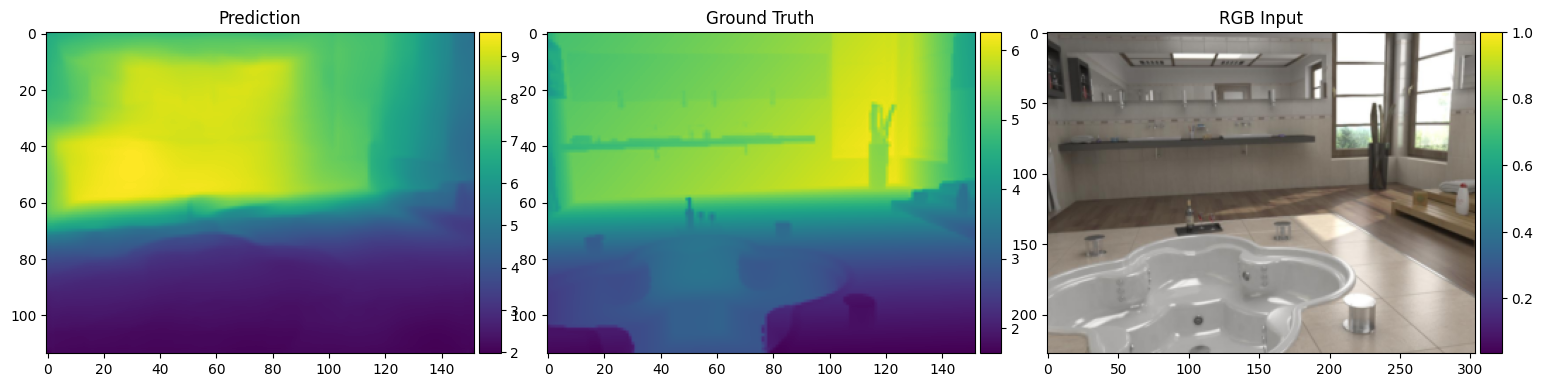

Depth max:  tensor(9.5683)
Depth min:  tensor(1.9758)
Depth groundtruth max:  tensor(6.2561)
Depth groundtruth min:  tensor(1.6435)
Error max:  tensor(4.6600)
Error min:  tensor(0.)


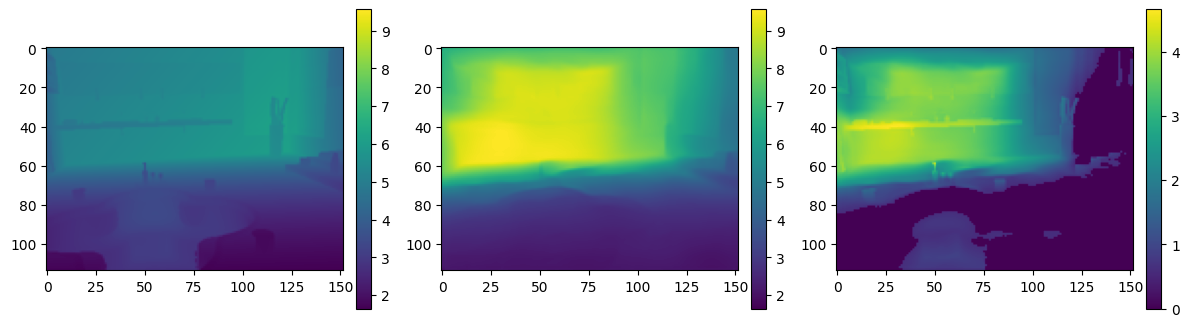

In [10]:
for tensors in depth_results:
    outputs,depths,rgbs = tensors
    outputs = outputs[0,:,:,:].cpu()
    depths = depths[0,:,:,:].cpu()
    rgbs = rgbs[0,:,:,:].cpu()
    display_tensor_data_many(tensors=[outputs,depths,rgbs],remap=[None,None,denormalize])
    display_image_triplets(depths, outputs)


### Loading outputs and printing them
This is not meaningfull since we are not able to get the same samples as while training/validating on cluster...
I will leave this commented for now

In [ ]:
# depth_outputs = torch.load(download_path+validation_tensor_path)

# print(depth_outputs.shape)

In [ ]:
# test_loader = getTestingData(1, validation_image_path_csv)

In [ ]:
# sample_batched = next(iter(test_loader))
# for i in range(depth_outputs.shape[0]):
#     curr_depth = depth_outputs[i,0,:,:,:].cpu()
#     # display_tensor_data(curr_depth.detach())
#     # display_tensor_data(sample_batched["depth"][0,:].detach())
#     # display_tensor_data(sample_batched["image"][0,:].detach(), denormalize)
#     # print("====")
#     display_tensor_data_many([curr_depth.detach(),sample_batched["depth"][0,:].detach(),sample_batched["image"][0,:].detach()],remap=[None,None,denormalize])

In [ ]:
# sample_batched = next(iter(test_loader))
# for i in range(depth_outputs.shape[0]):
#     curr_depth = depth_outputs[i,0,:,:,:].cpu()
#     print(i)
#     display_image_triplets(sample_batched["depth"][0,:].detach(), curr_depth.detach())
    

#### Plotting Losses


In [ ]:
resutls_csv_file_name = "train-results.csv"
results_csv = download_path + "../outputs/results/" + resutls_csv_file_name
results_df = pd.read_csv(results_csv)


In [ ]:
def plot_results(dataframe,title=None):
    fig = plt.figure()
    ax = fig.gca()
    x = list(range(results_df.shape[0]))
    x_ticks = list(range(0,results_df.shape[0],2))
    ax.set_xticks(x_ticks)
    line, = ax.plot(x,dataframe["loss_depth"],label="loss_depth")
    # line.set_label("loss_depth")
    line, = ax.plot(x,dataframe["loss_dx"],label="loss_dx")
    # line.set_label("loss_dx")
    line, = ax.plot(x,dataframe["loss_dy"],label="loss_dy")
    # line.set_label("loss_dy")
    line, = ax.plot(x,dataframe["loss_normal"],label="loss_normal")
    # line.set_label("loss_normal")
    line, = ax.plot(x,dataframe["loss"],label="loss")
    ax.set_xlabel("Epoch")
    if title is not None:
        ax.set_title(title)
    
    # line.set_label("loss_normal")
    ax.legend()
    plt.show()


In [ ]:
plot_results(results_df,"Training Losses")

In [ ]:
resutls_csv_file_name2 = "train-results2.csv"
results_csv2 = download_path + "../outputs/results/" + resutls_csv_file_name2
results_df2 = pd.read_csv(results_csv2)
plot_results(results_df2,"Training Losses of second run")

### Testing the model (Expecting you ran above cells and already loaded the model)

In [8]:
import test
torch.cuda.empty_cache()


In [9]:

test_loader = getTestingData(5, "test_data.csv")
test.test(test_loader, model, 2e-04)

My Method in dataloader is:  Method.NOSEGMENTATIONCUES
test: 0
tensor(-2.2293)
tensor(2.2083)


/home/user/ethz/semester4/3dVision/.3d-env/lib/python3.11/site-packages/torch/nn/functional.py:3737: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/home/user/ethz/semester4/3dVision/3DVision--Infusing-Monocular-Depth-Semantic/model/Revisiting_Single_Depth_Estimation-master/test.py:79: RuntimeWarning: invalid value encountered in scalar divide
  F = (2 * P * R) / (P + R) #precision and recall?


test: 1
tensor(-2.2293)
tensor(2.2083)
test: 2
tensor(-2.2293)
tensor(2.2083)
test: 3
tensor(-2.2129)
tensor(2.2083)
test: 4
tensor(-2.2293)
tensor(2.2083)
test: 5
tensor(-2.2293)
tensor(2.2083)
test: 6
tensor(-1.9996)
tensor(2.2083)
test: 7
tensor(-2.2293)
tensor(2.2083)
test: 8
tensor(-2.1308)
tensor(2.2083)
test: 9
tensor(-2.2293)
tensor(2.2083)
test: 10
tensor(-2.2293)
tensor(2.2083)
test: 11
tensor(-2.2129)
tensor(2.2083)
test: 12
tensor(-2.2293)
tensor(2.2083)
test: 13
tensor(-2.1473)
tensor(2.2083)
test: 14
tensor(-2.1801)
tensor(2.2083)
test: 15
tensor(-2.2129)
tensor(2.2083)
test: 16
tensor(-2.2293)
tensor(2.2083)
test: 17
tensor(-2.2293)
tensor(2.2083)
test: 18
tensor(-2.2293)
tensor(2.2083)
test: 19
tensor(-2.1637)
tensor(2.2083)
test: 20
tensor(-2.0980)
tensor(2.2083)
test: 21
tensor(-2.1473)
tensor(2.2083)
test: 22
tensor(-2.2293)
tensor(2.2083)
test: 23
tensor(-2.2293)
tensor(2.2083)
test: 24
tensor(-2.1965)
tensor(2.2083)
test: 25
tensor(-2.2129)
tensor(2.2083)
test: 26
